# 9. Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as ps
import pointpats as pp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Dodanie przygotowanych poprzednio funkcji

In [2]:
def point_count_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca liczbą punktów przypisanych do każdego z podobszarów.
    """

    Series = np.zeros(len(subregions))
    
    
    for i in range(len(subregions)):
        Series[i] = sum(points.within(subregions["geometry"][i]))
        
    Series = pd.Series(Series)

    return(Series)

def intensity_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    intensity: Series
        Seria Pandas zawierająca intensywność przypisaną do każdego z podobszarów.
    """
   
    Area = subregions.area
    Series = np.zeros(len(subregions))
    
    PC = point_count_on_subregions(points, subregions)
    
    
    for i in range(len(subregions)):
        Series[i] = PC[i]/Area[i]
    
    
    Series = pd.Series(Series)
    return(Series)

### Import i przygotowanie danych

In [3]:
Powiaty = gpd.read_file(".\Data\Powiaty.zip")
Points1 = gpd.read_file(".\Data\points_1.zip")
Points2 = gpd.read_file(".\Data\points_2.zip")
Points3 = gpd.read_file(".\Data\points_3.zip")
Points4 = gpd.read_file(".\Data\points_4.zip")
Points5 = gpd.read_file(".\Data\points_5.zip")

Kraj = gpd.GeoDataFrame.dissolve(Powiaty)

### Analiza Monte-Carlo na przykładzie funkcji G

Korzystając z funkcji `pointpats.distance_statistics.g_test()` przygotowano funkcję `g_test_mc()`, która będzie przeprowadzała analizę Monte-Carlo testowanego rozkładu funkcji oraz przygotowywała dane niezbędne do wizualizacji wyników testu.

Funkcja `pointpats.distance_statistics.g_test()` może zostać wykorzystana do wielokrotnego zasymulowania jednorodnego procesu poissona o intensywności równej intensywności testowanego procesu i wyliczeniu funkcji G dla każdego z zasymulowanych rozkładów. Funkcje te mogą posłużyć do wykreślenia obwiedni. Jeżeli funkcja G analizowanego rozkładu w całości znajduje się w obwiedni to nie pa podstaw do odrzucenia HO na rzecz H1. W przeciwnym przypadku następuje odrzucenie H0 na rzecz H1. Poziom istotności wykonywanego testu $\alpha= \frac{2}{n-1}$, gdzie $n$ to liczba wykonywanych symulacji.

Wykorzystano przygotowane funkcje do przetestowania rozkładów punktów z plików points_1.zip, points_2.zip i points_3.zip na poziomie istotności $\alpha=0.05$. 

#### a) Przygotowanie funkcji

In [4]:
def g_test_mc(points, intervals, polygon, number_of_simulations):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    intervals: int
        Liczba dodatnia określająca na ile części ma zostać podzielony dystans do największej odległosci do najbliższego sąsiada.
    polygon: Polygon
        Obszar, na którym mają zostać wygenerowane punkty procesu testowego.
    number_of_simulations: int
        Liczba dodania określająca liczbę wykonywanych symulacji.
    
    Returns
    -------
    g: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji G,
        - "G" - zawierającą wyliczone wartości funkcji G.
        - "G_min" - zawierającą dolne wartości obwiedni funkcji G.
        - "G_max" - zawierającą górne wartości obwiedni funkcji G.
    """  
    
    x = points["geometry"].x
    y = points["geometry"].y
    
    df = pd.DataFrame(data = {"X": x, "Y": y})
    
    Distnce_statistics = pp.distance_statistics.g_test(coordinates = df, support = intervals, hull = polygon, keep_simulations = True, n_simulations = number_of_simulations)
    
    
    G_min = np.zeros(len(Distnce_statistics[0]))
    G_max = np.zeros(len(Distnce_statistics[1]))
    
    simulations = Distnce_statistics[3]
    
    
    n=0
    for i in range(len(G_min)):
            G_min[i] = simulations[n][i]
            G_max[i] = simulations[n][i]
            
            for j in range(len(simulations)):
                for k in range(len(G_min)):
                    
                    if (G_min[k] > simulations[j][k]):
                        G_min[k] = simulations[j][k]
                
                    if (G_max[k] < simulations[j][k]):
                        G_max[k] = simulations[j][k]
                
    print("Analiza Monte-Carlo rozkładu punktów")
    print("H0: Testowana zmienna ma jednorodny rozkład losowy Poissona")
    print("H1: Testowana zmienna nie ma jednorodnego rozkładu losowego Poissona")   
    
    alpha = 2/(number_of_simulations - 1)
    
    
    H=1
    for i in range(len(G_min)):
        if (Distnce_statistics[1][i] < G_min[i] or Distnce_statistics[1][i] > G_max[i]):
            print("Odrzucenie hipotezy H0 na rzecz H1 na poziomie istotnosci alpha = " + str(round(alpha,2)))
            H=0
            break
       
    
    if (H==1):     
        print("Wynik test nie daje podstaw do odrzucenia H0 na rzecz H1 na poziomie istotnosci alpha = " + str(round(alpha,2)))
            
    print("\n")
         
    
    
    DF = pd.DataFrame(data = {"D": Distnce_statistics[0], "G": Distnce_statistics[1], "G_min": G_min, "G_max": G_max})
    
    return(DF)

#### b) Wygenerowanie danych

In [5]:
print("Analiza rozkładu Points1")
Points1_g_test = g_test_mc(Points1, 50, Kraj["geometry"][0], 41)

print("Analiza rozkładu Points2")
Points2_g_test = g_test_mc(Points2, 50, Kraj["geometry"][0], 41)

print("Analiza rozkładu Points3")
Points3_g_test = g_test_mc(Points3, 50, Kraj["geometry"][0], 41)

Analiza rozkładu Points1
Analiza Monte-Carlo rozkładu punktów
H0: Testowana zmienna ma jednorodny rozkład losowy Poissona
H1: Testowana zmienna nie ma jednorodnego rozkładu losowego Poissona
Odrzucenie hipotezy H0 na rzecz H1 na poziomie istotnosci alpha = 0.05


Analiza rozkładu Points2
Analiza Monte-Carlo rozkładu punktów
H0: Testowana zmienna ma jednorodny rozkład losowy Poissona
H1: Testowana zmienna nie ma jednorodnego rozkładu losowego Poissona
Odrzucenie hipotezy H0 na rzecz H1 na poziomie istotnosci alpha = 0.05


Analiza rozkładu Points3
Analiza Monte-Carlo rozkładu punktów
H0: Testowana zmienna ma jednorodny rozkład losowy Poissona
H1: Testowana zmienna nie ma jednorodnego rozkładu losowego Poissona
Odrzucenie hipotezy H0 na rzecz H1 na poziomie istotnosci alpha = 0.05




#### c) Wizualizacja

Text(0.5, 1.0, 'G function')

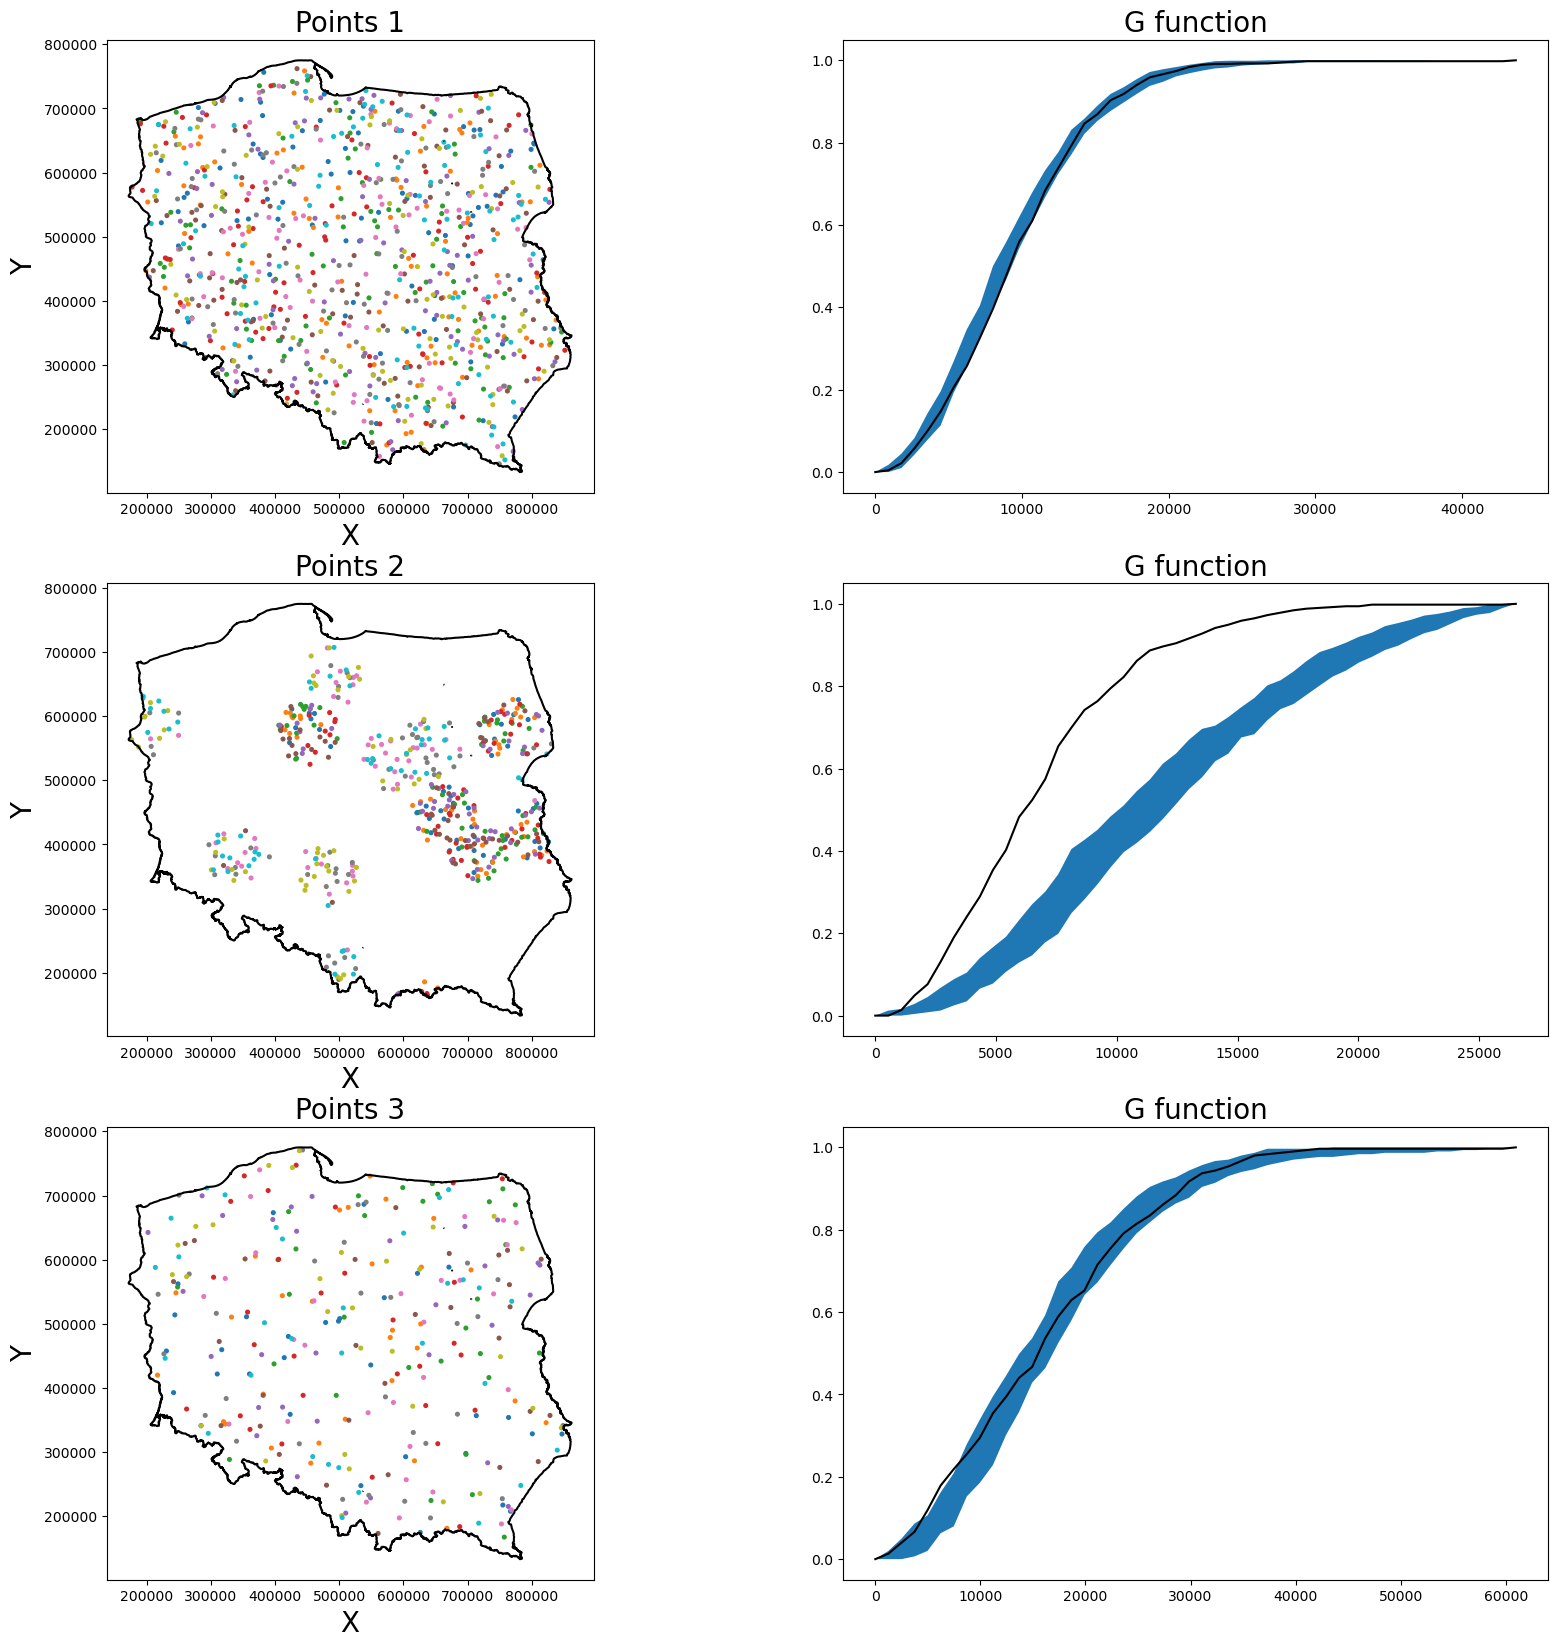

In [6]:
fig,((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(20,20))


Points1.plot(column = "geometry", markersize = 7, ax = ax1)
Kraj.boundary.plot(color = "black" ,ax = ax1)
ax1.set_title("Points 1", fontsize = 20)
ax1.set_xlabel("X", fontsize = 20)
ax1.set_ylabel("Y", fontsize = 20)

Points2.plot(column = "geometry", markersize = 7, ax = ax3)
Kraj.boundary.plot(color = "black" ,ax = ax3)
ax3.set_title("Points 2", fontsize = 20)
ax3.set_xlabel("X", fontsize = 20)
ax3.set_ylabel("Y", fontsize = 20)

Points3.plot(column = "geometry", markersize = 7, ax = ax5)
Kraj.boundary.plot(color = "black" ,ax = ax5)
ax5.set_title("Points 3", fontsize = 20)
ax5.set_xlabel("X", fontsize = 20)
ax5.set_ylabel("Y", fontsize = 20)


ax2.plot(Points1_g_test["D"], Points1_g_test["G"], c="black")
ax2.fill_between(Points1_g_test["D"], Points1_g_test["G_min"], Points1_g_test["G_max"])
ax2.set_title("G function", fontsize = 20)

ax4.plot(Points2_g_test["D"], Points2_g_test["G"], c="black")
ax4.fill_between(Points2_g_test["D"], Points2_g_test["G_min"], Points2_g_test["G_max"])
ax4.set_title("G function", fontsize = 20)

ax6.plot(Points3_g_test["D"], Points3_g_test["G"], c="black")
ax6.fill_between(Points3_g_test["D"], Points3_g_test["G_min"], Points3_g_test["G_max"])
ax6.set_title("G function", fontsize = 20)

### Autokorelacja przestrzenna danych

Przygotowano funkcję `spatial_autocorelation_data()`, która będzie przygotowywać dane niezbędne do oceny autokorelacji przestrzennej analizowanych danych.

Schemat postępowania:
- zagregowanie danych na obszarze poszczegolnych powiatów (ze względu na różnice w powierzchni obszarów skorzystano z wyliczonych dla nich wartości intensywności, a nie samej liczby zliczeń w ich obrębie),
- wyznaczenie macierzy wag przestrzennych,
- wyliczenie opóźnienia przestrzennego,
- przygotowanie danych niezbędnych do wykonania wykresu Morana.

#### a) Przygotowanie funkcji

In [7]:
def spatial_autocorelation_data(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    moran_plot_data: GeoDataFrame
        Obiekt GeoDataFrame zawierający następujące kolumny:
        "geometry" - kolumna z geometrią podobszarów,
        "intensity" - wartości intesywności procesu w obrębie poszczególnych podobszarów,
        "lag" - wartości opóźnienia przestrzennego w obrębie poszczególnych podobszarów,
        "intensity_std" - ustandaryzowane wartości intensywności.
        "lag_std" - ustandaryzowane wartości opóźnienia przestrzennego.
    """    
    
    intensity = intensity_on_subregions(points, subregions)
    
    
    weights = ps.weights.Rook(subregions["geometry"])
    
    lag = ps.weights.lag_spatial(weights, intensity)
    
     
    avg_intensity = sum(intensity)/len(intensity)
    avg_lag = sum(lag)/len(lag)
    
    
    intensity_std = intensity - avg_intensity
    lag_std = lag - avg_lag
    
    
    moran_plot_data = gpd.GeoDataFrame(data = {"intensity": intensity, "lag": lag, "intensity_std": intensity_std, "lag_std": lag_std}, geometry = subregions["geometry"])
    
    
    return(moran_plot_data)

#### b) Wygenerowanie danych

In [8]:
Points4_autocorelation = spatial_autocorelation_data(Points4, Powiaty)
Points5_autocorelation = spatial_autocorelation_data(Points5, Powiaty)

#### c) Wizualizacja

Text(1058.0517676767674, 0.5, 'Lag std')

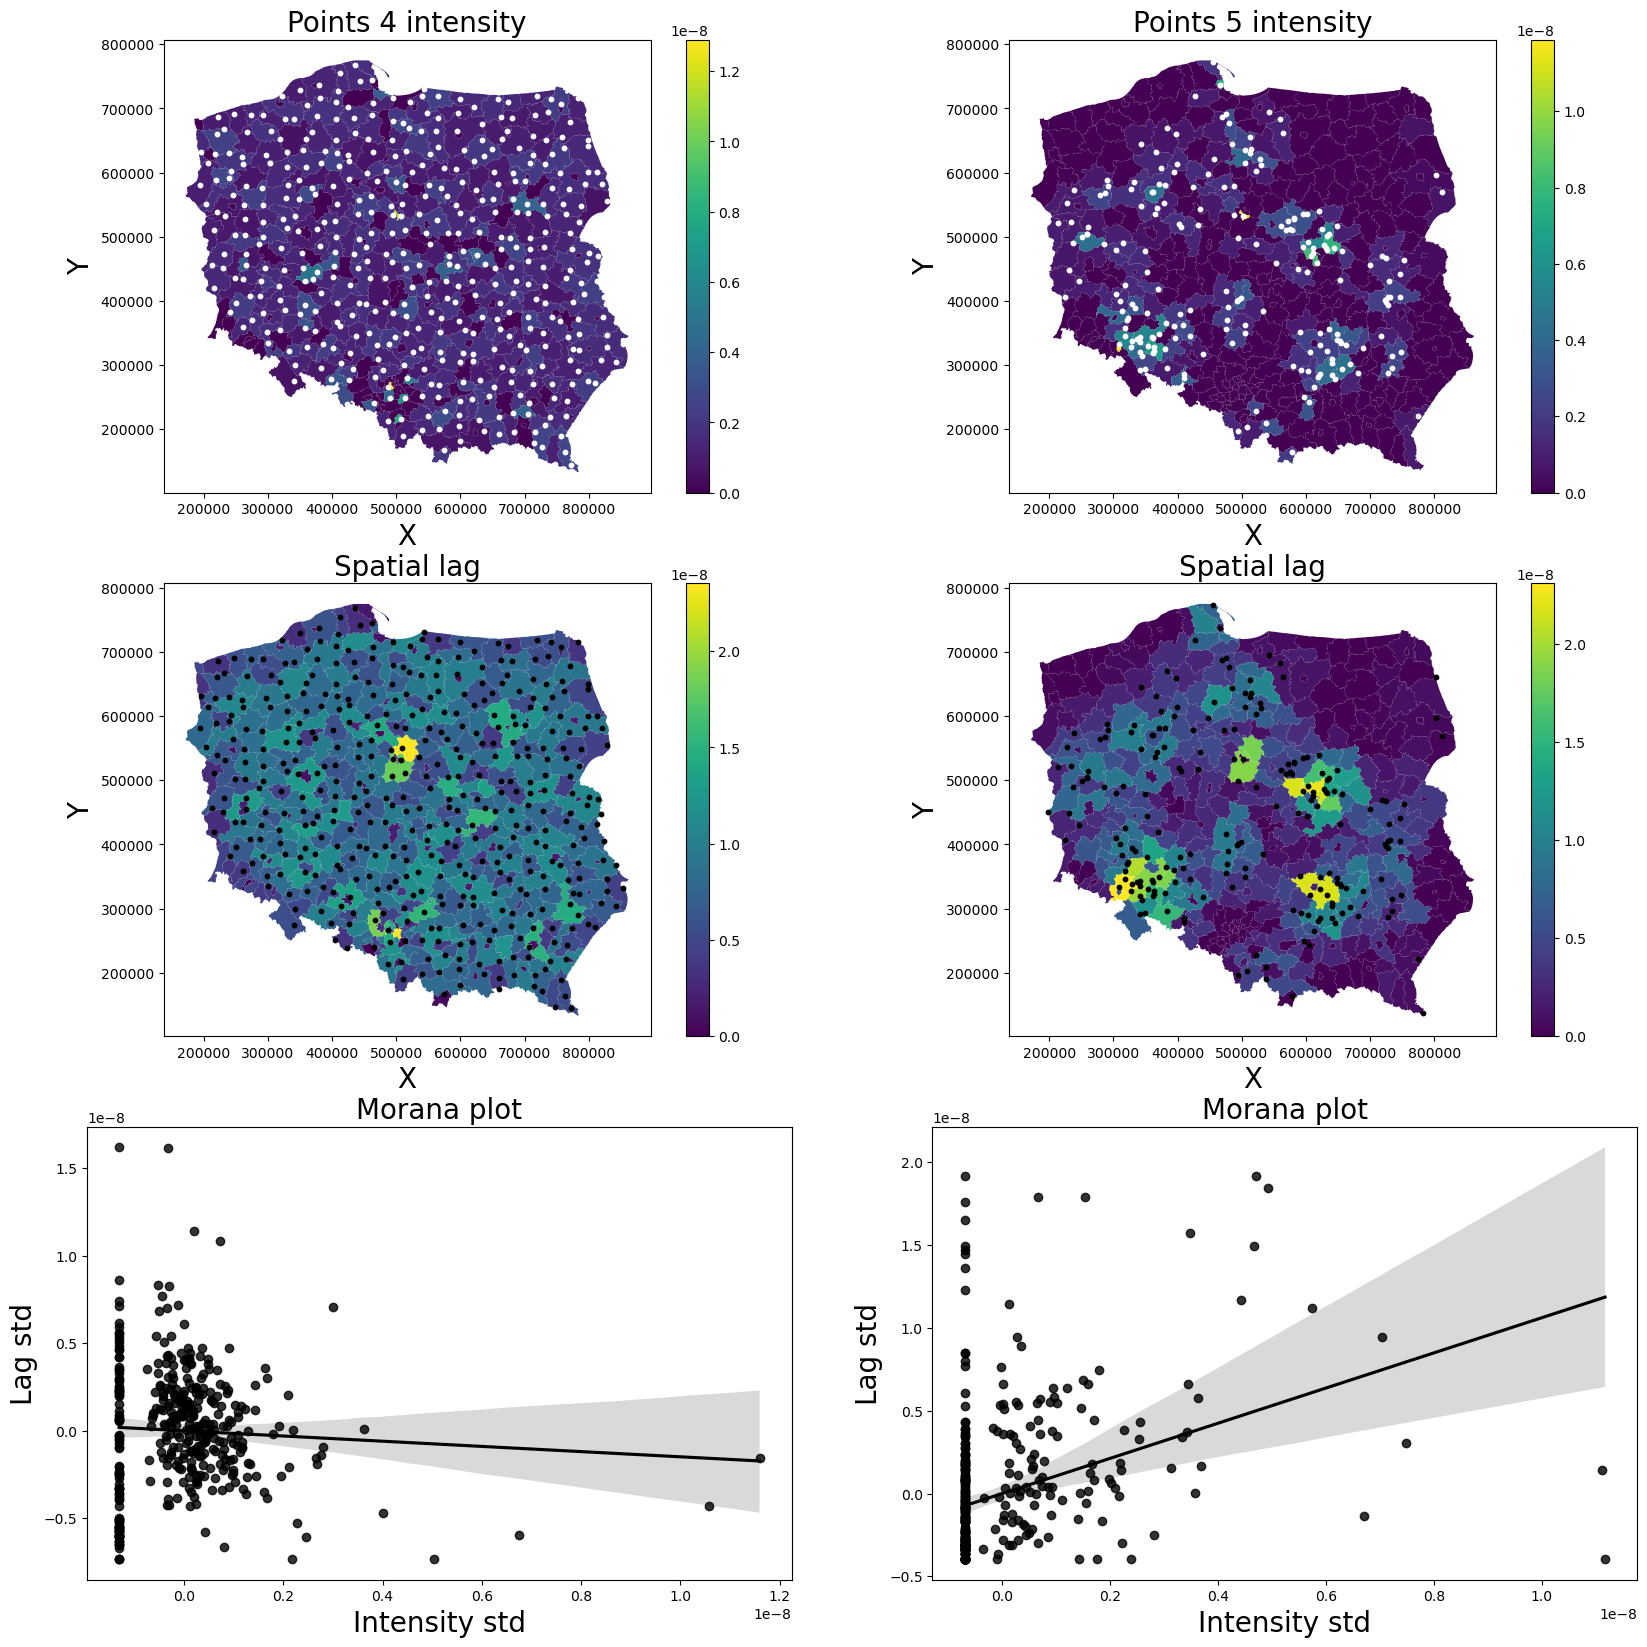

In [10]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize=(20,20))


Points4_autocorelation.plot(column = "intensity", ax=ax1, legend = True)
Points4.plot(ax=ax1, markersize = 10, color = "white")
ax1.set_title("Points 4 intensity", fontsize = 20)
ax1.set_xlabel("X", fontsize = 20)
ax1.set_ylabel("Y", fontsize = 20)

Points4_autocorelation.plot(column = "lag", ax=ax3, legend = True)
Points4.plot(ax=ax3, markersize = 10, color = "black")
ax3.set_title("Spatial lag", fontsize = 20)
ax3.set_xlabel("X", fontsize = 20)
ax3.set_ylabel("Y", fontsize = 20)

sns.regplot(data = Points4_autocorelation, x = "intensity_std", y = "lag_std", ax= ax5, color ="black")
ax5.set_title("Morana plot", fontsize = 20)
ax5.set_xlabel("Intensity std", fontsize = 20)
ax5.set_ylabel("Lag std", fontsize = 20)


Points5_autocorelation.plot(column = "intensity", ax=ax2, legend = True)
Points5.plot(ax=ax2, markersize = 10, color = "white")
ax2.set_title("Points 5 intensity", fontsize = 20)
ax2.set_xlabel("X", fontsize = 20)
ax2.set_ylabel("Y", fontsize = 20)

Points5_autocorelation.plot(column = "lag",cmap = "viridis", ax=ax4, legend = True)
Points5.plot(ax=ax4, markersize = 10, color = "black")
ax4.set_title("Spatial lag", fontsize = 20)
ax4.set_xlabel("X", fontsize = 20)
ax4.set_ylabel("Y", fontsize = 20)

sns.regplot(data = Points5_autocorelation, x = "intensity_std", y = "lag_std", ax= ax6, color ="black")
ax6.set_title("Morana plot", fontsize = 20)
ax6.set_xlabel("Intensity std", fontsize = 20)
ax6.set_ylabel("Lag std", fontsize = 20)